In [1]:
import numpy as np
import tensorflow as tf
import sonnet as snt

import matplotlib.pyplot as plt
% matplotlib inline

from neurocity.tools.params import num_trainable_params

from data import create_mnist
from model import AIRCell

In [2]:
learning_rate = 1e-4
batch_size = 64
img_size = 50, 50
crop_size = 20, 20
n_latent = 50
n_hidden = 256
n_steps = 3

In [3]:
data = create_mnist(n_samples=60000)

Extracting data/MNIST_data/train-images-idx3-ubyte.gz
Extracting data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting data/MNIST_data/t10k-labels-idx1-ubyte.gz


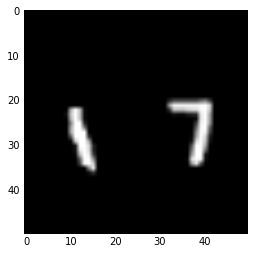

In [4]:
imgs = data['imgs']
plt.imshow(imgs[2], cmap='gray')

In [5]:
tf.reset_default_graph()
x = tf.placeholder(tf.float32, (batch_size,) + img_size, name='inpt')

transition = snt.GRU(n_hidden)
air = AIRCell(img_size, crop_size, n_latent, transition)
initial_state = air.initial_state(x)

dummy_sequence = tf.zeros((n_steps, batch_size, 1), name='dummy_sequence')
outputs, state = tf.nn.dynamic_rnn(air, dummy_sequence, initial_state=initial_state, time_major=True)
canvas, cropped, what, where, presence_logit = outputs
presence = tf.nn.sigmoid(presence_logit)

cropped = tf.reshape(tf.nn.sigmoid(cropped), (n_steps, batch_size,) + tuple(crop_size))
canvas = tf.reshape(canvas, (n_steps, batch_size,) + tuple(img_size))
prob_canvas = tf.nn.sigmoid(canvas)
final_canvas = canvas[-1]

In [6]:
print num_trainable_params()

1184670


In [7]:
# loss = ((x - final_canvas)**2
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=x, logits=final_canvas)

loss = tf.reduce_mean(tf.reduce_sum(loss, axis=(1, 2)))

alpha= 1.
num_steps = tf.reduce_mean(tf.reduce_sum(presence, 0))
num_steps_penalty = alpha * num_steps

loss += num_steps_penalty

opt = tf.train.AdamOptimizer(learning_rate)
train_step = opt.minimize(loss)

In [8]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [9]:
# xx = np.random.rand(*x.get_shape().as_list())
xx = data['imgs']

In [ ]:
imgs = data['imgs']
for train_itr in xrange(100000):
    
    idx = np.random.choice(imgs.shape[0], batch_size)
    xx = imgs[idx]
    
    sess.run(train_step, {x: xx})
    if train_itr % 100 == 0:
        l = sess.run(loss, {x: xx})
        print train_itr, l

0 99.1242
100 88.9439
200 81.6377
300 104.136
400 108.928
500 87.9247


In [11]:
pred_canvas, pred_crop = sess.run([prob_canvas, cropped], {x: xx})

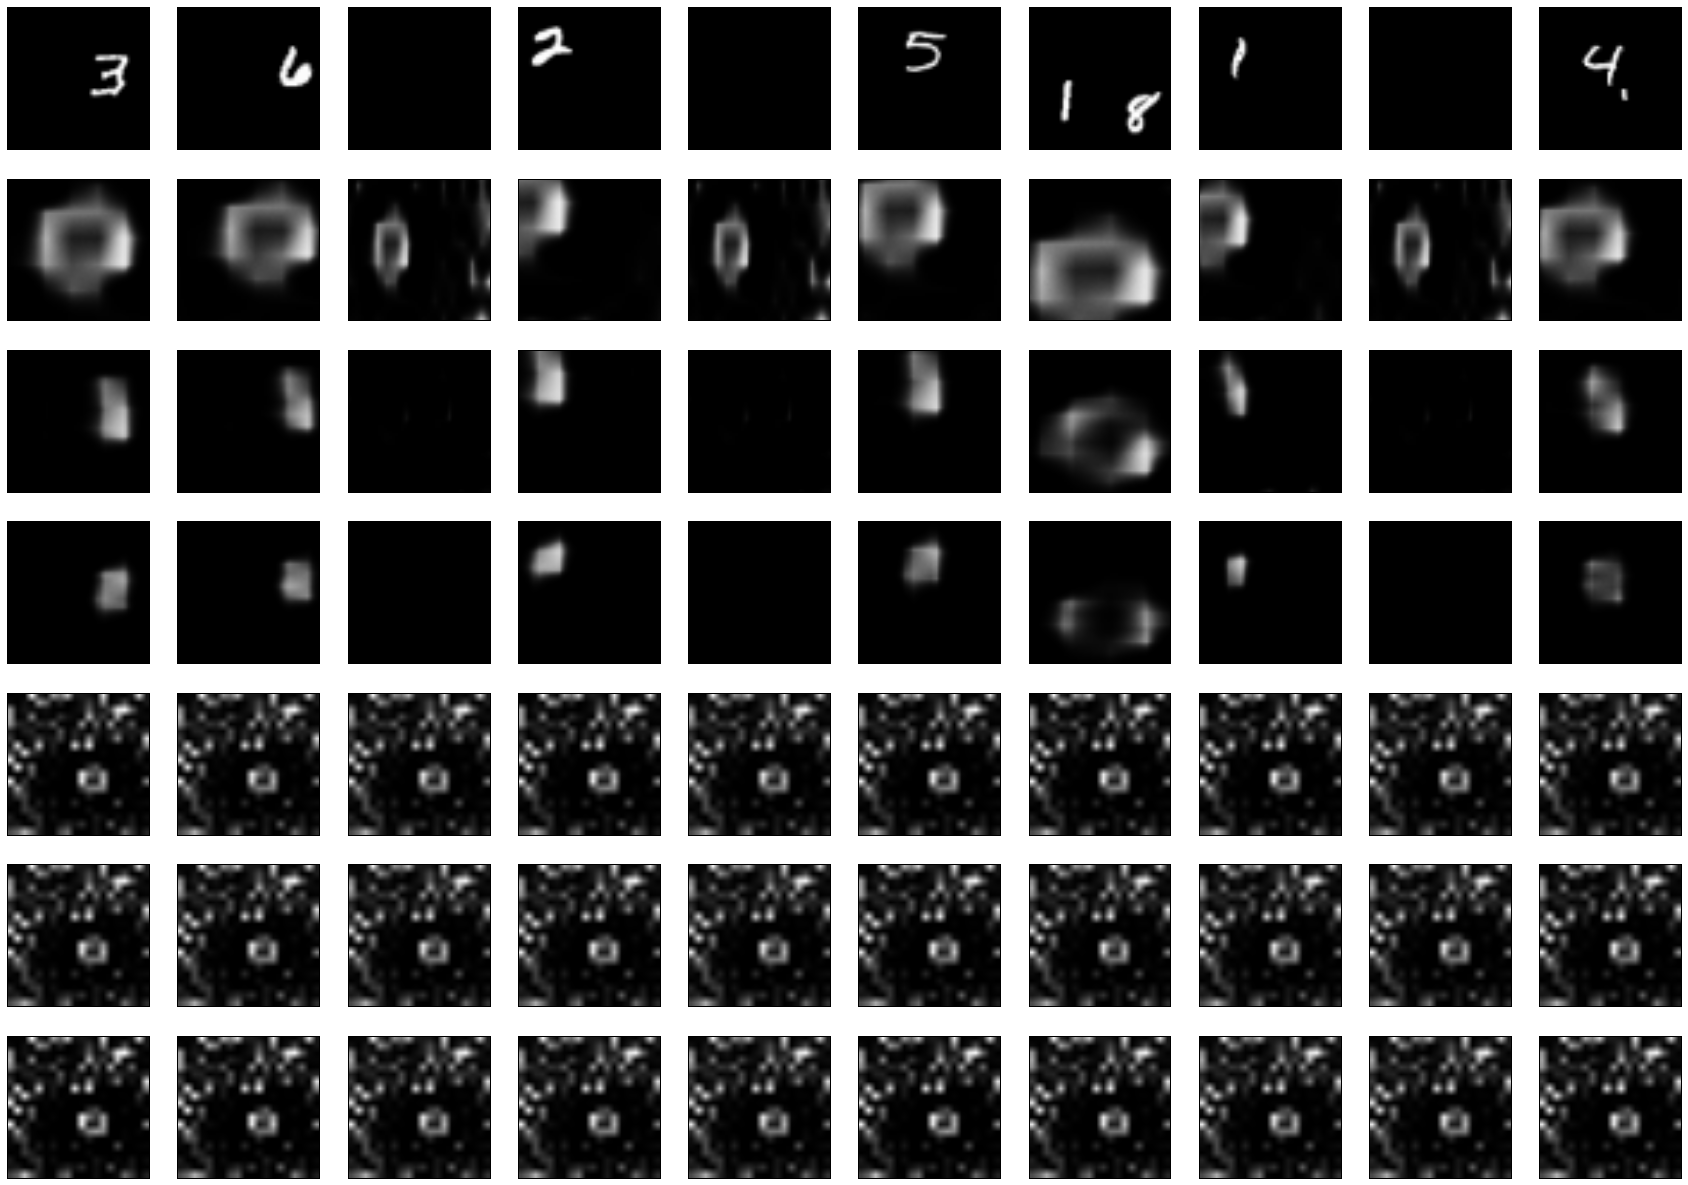

In [12]:
max_imgs = 10
bs = min(max_imgs, batch_size)
scale = 3.
figsize = scale * np.asarray((bs, 2 * n_steps + 1))
fig, axes = plt.subplots(2 * n_steps + 1, bs, figsize=figsize)

for i, ax in enumerate(axes[0]):
    ax.imshow(xx[i], cmap='gray', vmin=0, vmax=1)
    
for i, ax_row in enumerate(axes[1:1+n_steps]):
    for j, ax in enumerate(ax_row):
        ax.imshow(pred_canvas[i, j], cmap='gray', vmin=0, vmax=1)
        
for i, ax_row in enumerate(axes[1+n_steps:]):
    for j, ax in enumerate(ax_row):
        ax.imshow(pred_crop[i, j], cmap='gray', vmin=0, vmax=1)
    
for ax in axes.flatten():
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)